### Imports

In [7]:
import pandas as pd
import numpy as np
from ta import add_all_ta_features

from pandas_datareader.data import DataReader

import yfinance as yf
yf.pdr_override()


# Statistics
from statsmodels.tsa.stattools import adfuller

# Machine Learning
from sklearn.decomposition import PCA

# Supervised Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score


# Plotting - Visualization
import matplotlib.pyplot as plt


### Data Extraction

In [9]:
start_date = '2017-01-01'
end_date = '2024-01-01'
symbol='^VIX'

df=DataReader(symbol,start_date,end_date)
df.head()

[*********************100%%**********************]  1 of 1 completed

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,14.07,14.07,12.85,12.85,12.85,0
2017-01-04,12.78,12.80,11.63,11.85,11.85,0
2017-01-05,11.96,12.09,11.40,11.67,11.67,0
2017-01-06,11.70,11.74,10.98,11.32,11.32,0
2017-01-09,11.71,12.08,11.46,11.56,11.56,0


### Feautre Engineering

In [12]:
# Add Technical Analysis Features

df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Adj Close", volume="Volume", fillna=True)
df.shape

(1760, 92)

In [15]:
# Data preprocessing - Stationarity
    # identify non-stationary features

non_stationary_features = []
for col in df.columns:
    df_test = adfuller(df[col].values, autolag='AIC')
    p_value = df_test[1]
    t_test = df_test[0] < df_test[4]['1%']

    if p_value > 0.05 or not t_test:
        non_stationary_features.append(col)

print(f"non-stationary features: {len(non_stationary_features)}")

c:\Users\Kreator\anaconda3\envs\MLTRADE\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\Kreator\anaconda3\envs\MLTRADE\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\Kreator\anaconda3\envs\MLTRADE\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\Kreator\anaconda3\envs\MLTRADE\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\Kreator\anaconda3\envs\MLTRADE\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by 

non-stationary features: 23


In [19]:
# Convert to stationary

df_stationary = df.copy()
df_stationary[non_stationary_features] = df_stationary[non_stationary_features].pct_change()
df_stationary.iloc[1:]
df_stationary.head()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,14.07,14.07,12.85,12.85,12.85,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,12.850000,-33.169999,0.000000,0.000000
2017-01-04,12.78,12.80,11.63,11.85,11.85,NaN,NaN,NaN,NaN,NaN,...,-0.624394,-0.124879,-0.499515,NaN,NaN,NaN,12.713180,-7.782101,-8.101594,-7.782101
2017-01-05,11.96,12.09,11.40,11.67,11.67,NaN,NaN,NaN,NaN,NaN,...,-1.226732,-0.345249,-0.881483,NaN,NaN,NaN,12.552661,-1.518990,-1.530645,-9.182881
2017-01-06,11.70,11.74,10.98,11.32,11.32,NaN,NaN,NaN,NaN,NaN,...,-1.916831,-0.659566,-1.257265,NaN,NaN,NaN,11.768279,-2.999146,-3.045041,-11.906620
2017-01-09,11.71,12.08,11.46,11.56,11.56,NaN,NaN,NaN,NaN,NaN,...,-2.289756,-0.985604,-1.304152,NaN,NaN,NaN,11.681773,2.120148,2.097985,-10.038910


In [25]:
na_list = df_stationary.columns[df_stationary.isna().any().tolist()]
df_stationary.drop(columns=na_list,inplace=True)

df_stationary.replace([np.inf, -np.inf], 0, inplace=True)
df_stationary.head()

,Open,High,Low,Close,Adj Close,volatility_bbm,volatility_bbh,volatility_bbw,volatility_bbp,volatility_bbhi,...,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,14.07,14.07,12.85,12.85,12.85,12.850000,12.850000,0.000000,0.000000,0.0,...,-100.000000,0.0,0.0,0.000000,0.000000,0.000000,12.850000,-33.169999,0.000000,0.000000
2017-01-04,12.78,12.80,11.63,11.85,11.85,12.350000,13.350000,16.194331,0.250000,0.0,...,-90.983594,0.0,0.0,-0.624394,-0.124879,-0.499515,12.713180,-7.782101,-8.101594,-7.782101
2017-01-05,11.96,12.09,11.40,11.67,11.67,12.123334,13.161452,17.125952,0.281656,0.0,...,-89.887624,0.0,0.0,-1.226732,-0.345249,-0.881483,12.552661,-1.518990,-1.530645,-9.182881
2017-01-06,11.70,11.74,10.98,11.32,11.32,11.922500,13.059283,19.069543,0.234998,0.0,...,-88.996759,0.0,0.0,-1.916831,-0.659566,-1.257265,11.768279,-2.999146,-3.045041,-11.906620
2017-01-09,11.71,12.08,11.46,11.56,11.56,11.850000,12.907318,17.845024,0.362861,0.0,...,-81.229746,0.0,0.0,-2.289756,-0.985604,-1.304152,11.681773,2.120148,2.097985,-10.038910


### Data preprocessing - Scaling and Target selection

In [27]:
# Set Target - for supervised learning
df_stationary['target'] = -1
df_stationary.loc[df_stationary['Adj Close'].shift(-1) > df_stationary['Adj Close'], 'target'] = 1
df_stationary.dropna(inplace=True)

In [28]:
# Split target from features
X = df_stationary.iloc[:, :-1]
y = df_stationary.iloc[:, -1]


In [29]:
# Feauture Scaling
df_scaled = df_stationary.copy()
X_fs = StandardScaler().fit_transform(X)

In [30]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_fs, y, test_size=0.7, random_state=42)

### Unsupervised Learning - PCA Dimensionality Reduction

In [54]:
# PCA
number_of_components = 8
pca = PCA(n_components=number_of_components)
pca_result = pca.fit(X_train)
X_train_pca = pca_result.transform(X_train)
X_test_pca = pca_result.transform(X_test)

# Calculate explained variance

print(f"Variance of each component: {pca.explained_variance_ratio_}")
print(f"Total Variance Explained: {round(sum(list(pca.explained_variance_ratio_))*100, 2)}%")

Variance of each component: [0.33627334 0.25801804 0.09739446 0.04745939 0.03484336 0.03029863
 0.02646541 0.01869031]
Total Variance Explained: 84.94%


In [55]:
# Create Column Names for PCA Components
pca_columns = []
for i in range(number_of_components):
    pca_columns.append(f"pca_{i+1}")

pca_columns

['pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']

In [56]:
# Create Dataframe with PCA Components

df_pca = pd.DataFrame(X_train_pca, columns=pca_columns)
df_pca.head()

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8
0,-2.422781,-2.480256,0.541529,-0.523864,1.497015,0.740685,0.935537,-0.920355
1,-0.096494,-3.061680,-1.141593,-1.030646,-0.837230,-1.801924,-0.705115,1.370816
2,-0.344051,6.648545,-5.891591,-0.563817,-1.052263,-1.270107,0.644739,-2.315652
3,2.705123,-4.626522,4.148102,-0.804252,0.483206,-1.165951,-0.685720,-0.323988
4,-0.556934,4.913884,-2.586628,-0.332116,-0.378042,-0.484311,0.621166,-0.540430


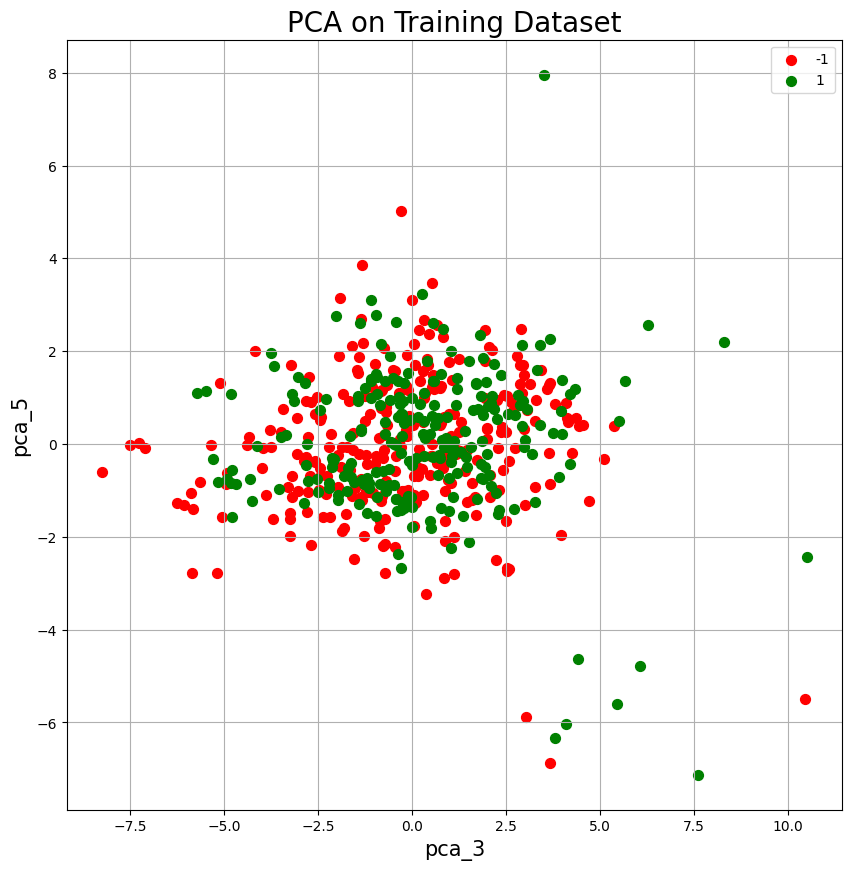

In [57]:
# Visualize PCA Components

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
col_1 = "pca_3"
col_2 = "pca_5"

ax.set_xlabel(col_1, fontsize=15)
ax.set_ylabel(col_2, fontsize=15)
ax.set_title('PCA on Training Dataset', fontsize=20)

targets = [-1, 1]
colors = ['r', 'g']
for target, color in zip(targets, colors):
    indicesToKeep = y_train == target
    indicesToKeep = list( indicesToKeep)
    ax.scatter(df_pca.loc[indicesToKeep, col_1]
               , df_pca.loc[indicesToKeep, col_2]
               , c=color
               , s=50)
    
ax.legend(targets)
ax.grid()

### Supervised ML - Random Forest Classifier

In [58]:
classifier = RandomForestClassifier(n_estimators=12,max_depth=2, random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy*100, 2)}%")
print(f"Precision: {round(precision*100, 2)}%")

Accuracy: 54.63%
Precision: 45.34%


In [59]:
y_pred_prob=classifier.predict_proba(X_test)
y_pred_prob

array([[0.55898862, 0.44101138],
       [0.55898862, 0.44101138],
       [0.52714529, 0.47285471],
       ...,
       [0.57075309, 0.42924691],
       [0.61945821, 0.38054179],
       [0.58417049, 0.41582951]])

In [61]:
# Overfitting

train_scores = []
test_scores = []

for i in range(1, 200):
    classifier = RandomForestClassifier(n_estimators=i,max_depth=2, random_state=0)
    classifier.fit(X_train, y_train)
   
    y_train_pred = classifier.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    train_scores.append(accuracy_train)

    y_test_pred = classifier.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    test_scores.append(accuracy_test)

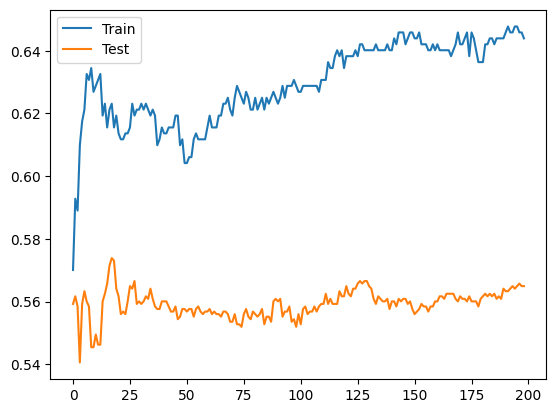

In [62]:
# plot the results

plt.plot(train_scores, label="Train")
plt.plot(test_scores, label="Test")
plt.legend()
plt.show()

In [77]:
# For 19 estimators

classifier = RandomForestClassifier(n_estimators=19,max_depth=2, random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy*100, 2)}%")
print(f"Precision: {round(precision*100, 2)}%")

Accuracy: 57.31%
Precision: 56.43%
